<a href="https://colab.research.google.com/github/xerifg/Myipynb/blob/main/pytorch%2BMINIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 忽视后续运行代码时出现的烦人红色提示
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# 导入深度学习框架pytorch和计算机库numpy
import torch
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['font.sans-serif']=['SimHei']  #用来正确显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正确显示负号

# **导入MINIST数据集**

In [ ]:
from torchvision import datasets   #数据集
import torchvision.transforms as transforms  #数据转换
from torch.utils.data.sampler import SubsetRandomSampler  #数据采样

# 载入数据时使用的处理器个数
num_workers = 0
# 每一批的数据个数
batch_size = 20
# 验证集所占比例
valid_size = 0.2
# 将数据转换为pytorch的张量tensor类型
transform = transforms.ToTensor()
# 选择数据集和测试集
# root:数据集所在目录
# train:是否载入训练集
# download :如果目录中没有数据集，是否自动下载
# transform:将将载入的数据按上面transform定义的方式进行转换
train_data = datasets.MNIST(root='data',train=True,download=True,transform=transform)
test_data = datasets.MNIST(root='data',train=False,download=True,transform=transform)

# 将训练集每张图像对应的索引随机打乱，将索引分为训练集索引和验证集索引
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size*num_train))
train_idx, valid_idx = indices[split:],indices[:split]

# 划分为新的训练集和验证集
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

#创建训练集、验证集、测试集的数据Loader，python中的生成器，每一次调用返回一个batch大小的数据
train_loader = torch.utils.data.DataLoader(train_data,batch_size=batch_size,sampler=train_sampler,num_workers=num_workers) #num_workers:使用全部的CPU
valid_loader = torch.utils.data.DataLoader(train_data,batch_size=batch_size,sampler=valid_sampler,num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data,batch_size=batch_size,num_workers=num_workers)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



# **可视化数据集**

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


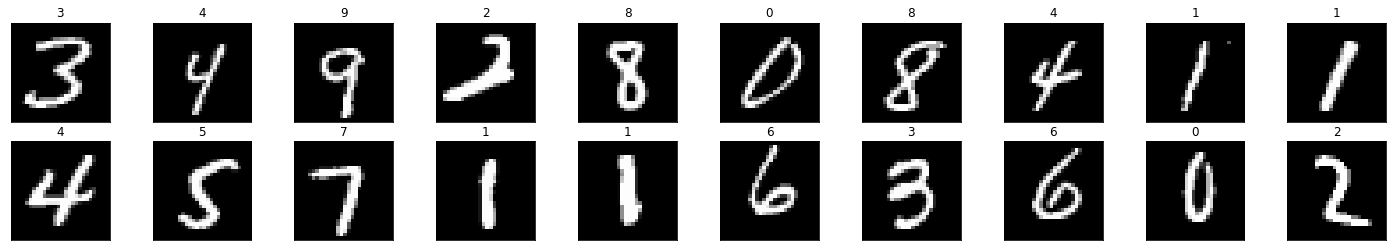

In [ ]:
# 可重复运行，展示不同的图片

# 构建迭代器，获取训练集中的一批次数据
dataiter = iter(train_loader)
images,labels = dataiter.next()
# 将数据集中的tensor张量转换为numpy的array数据结构
images = images.numpy()

# 可视化图片与标签
fig = plt.figure(figsize=(25,4))
for idx in np.arange(20):
  ax = fig.add_subplot(2,20/2,idx+1,xticks=[],yticks=[])
  ax.imshow(np.squeeze(images[idx]),cmap='gray')
  ax.set_title(str(labels[idx].item()))  # .item()获取张量的数值

# **展示图像的细节信息**

In [ ]:
images[1].shape

(1, 28, 28)

In [ ]:
np.squeeze(images[1]).shape

(28, 28)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


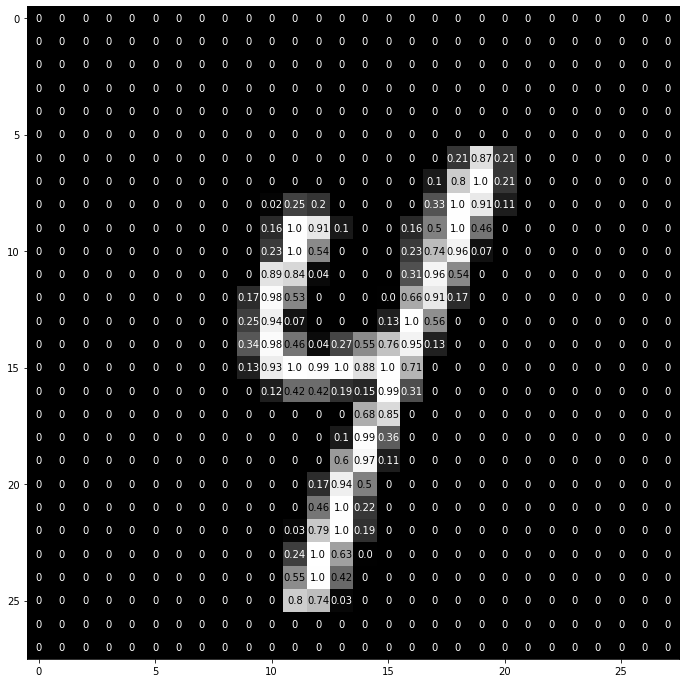

In [ ]:
# 去掉图像的批次维度，只保留索引为1的单张图像的长宽像素值
img = np.squeeze(images[1])

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
ax.imshow(img,cmap='gray')
width,height = img.shape
thresh = img.max()/2.5

# 遍历每一行每一列每一个像素
for x in range(width):
  for y in range(height):
    # 像素值保留两位小数，如果为0则显示为0
    val = round(img[x][y],2) if img[x][y] !=0 else 0
    ax.annotate(str(val),xy=(y,x),horizontalalignment='center',verticalalignment='center',color='white' if img[x][y]<thresh else 'black')  # 在像素上标注信息

# **定义神经网络**

输入为784维的向量，输出为10个数字对应的概念；
中间是两层隐含层，每个隐含层都有512个神经元；
采用dropoout防止过拟合；
全连接神经网络

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    #定义第一个隐含层和第二个隐含层的神经元个数
    hidden_1 = 512
    hidden_2 = 512

    # 输入层到隐含层，输入维度为784，输出维度为hidden_1
    self.fc1 = nn.Linear(28*28,hidden_1)
    # 第一层隐含层到第二层隐含层，输入维度为hidden_1，输出维度为hidden_2
    self.fc2 = nn.Linear(hidden_1,hidden_2)
    # 第二层隐含层到第三层隐含层，输入维度为hidden_2，输出维度为10
    self.fc3 = nn.Linear(hidden_2,10)
    # 定义Dropout率为0.2，防止过拟合
    self.dropout = nn.Dropout(0.2)

  def forward(self,x):
    #将原始图像拉成784维的长向量
    x = x.view(-1,28*28)
    #经过第一层隐含层，激活函数为relu
    x = F.relu(self.fc1(x))
    # Dropout层
    x = self.dropout(x)
    #经过第二层隐含层，激活函数为relu
    x = F.relu(self.fc2(x))
    # Dropout层
    x = self.dropout(x)
    #输出层
    x = self.fc3(x)
    return x
    
#实例化模型，打印模型信息
model = Net()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


# **定义损失函数和剃度下降优化器**

使用交叉熵作为分类问题的损失函数，pytorch中的交叉熵包含了softmax和对数损失的计算

In [ ]:
# 损失函数为交叉熵损失函数
criterion = nn.CrossEntropyLoss()
# 定义优化器（随机梯度下降SGD优化器，学习率0.01）
optimizer = torch.optim.SGD(model.parameters(),lr=0.01)

# **训练神经网络**

1. 清除所有的梯度 optimizer.zero_grad()
2. 正向预测，求出模型对训练集数据的预测分类结果 output = model(data)
3. 计算损失函数 loss = criterion(output,target)
4. 反向传播，将损失函数对每个权重求偏导，求得每个权重对应的梯度loss.backward()
5. 优化器执行单步的优化（权重更新）optimizer.step()
6. 计算每一轮的平均训练误差和验证误差

In [ ]:
len(train_loader.dataset)

60000

In [ ]:
# 训练轮次数，每一轮都完整遍历数据集中的所有图像
n_epochs = 10
# 初始化验证集的最小误差为正无穷
valid_loss_min = np.Inf
# 将训练过程中的训练损失和验证损失存储在列表中
train_loss_list = []
val_loss_list = []

# 每一轮的训练:
for epoch in range(n_epochs):
  # 初始化训练损失和验证损失
  train_loss = 0.0
  valid_loss = 0.0

  ## 训练阶段 ##
  model.train() #将模式调整为训练模式

  # 从train_loader中获取一批次的数据和标签
  for data,target in train_loader:
    # 将所有梯度归零
    optimizer.zero_grad()
    # 正向推断，求得预测结果
    output = model(data)
    # 将预测的结果与标签进行比较，求得交叉熵损失函数值
    loss = criterion(output,target)
    # 反向传播，将损失函数对每个权重求偏导，求得每个权重对应的梯度
    loss.backward()
    # 优化器执行单步的优化（权重更新）
    optimizer.step()
    # 将本批次所有的样本损失函数的值求和，作为训练损失
    train_loss += loss.item()*data.size(0)

    ## 验证阶段  ##
    model.eval() #将模型调整为验证阶段，关闭Dropout和BN层
    # 从验证集valid_loader中获取一个批次的数据和标签
  for data,target in valid_loader:
    # 正向预测，预测每张图片的分类
    output = model(data)
    # 将预测的结果与标签进行比较，求得交叉熵损失函数值
    loss = criterion(output,target)
    # 将本批次所有的样本损失函数的值求和，作为验证损失
    valid_loss += loss.item()*data.size(0)

  ## 结束了本论的训练和验证，打印训练和验证指标
  # 计算平均训练损失和平均验证损失，存储在列表中
  train_loss = train_loss/len(train_loader.dataset)
  valid_loss = valid_loss/len(valid_loader.dataset)
  train_loss_list.append(train_loss)
  val_loss_list.append(valid_loss)

  print('第{}轮 \t训练损失：{:.6f}\t验证损失：{:.6f}'.format(epoch+1,train_loss,valid_loss))

  #如果验证误差比上一次的小，及时保存模型到本地的model.pt文件中
  if valid_loss <= valid_loss_min:
    print('验证损失相比之前降低了（{:.6f}-->{:.6f}）.保存模型'.format(valid_loss_min,valid_loss))
    torch.save(model.state_dict(),'model.pt')
    valid_loss_min = valid_loss




第1轮 	训练损失：0.003511	验证损失：0.015600
验证损失相比之前降低了（inf-->0.015600）.保存模型
第2轮 	训练损失：0.003333	验证损失：0.015514
验证损失相比之前降低了（0.015600-->0.015514）.保存模型
第3轮 	训练损失：0.003142	验证损失：0.015659
第4轮 	训练损失：0.003011	验证损失：0.015548
第5轮 	训练损失：0.002901	验证损失：0.016039
第6轮 	训练损失：0.002750	验证损失：0.015744
第7轮 	训练损失：0.002608	验证损失：0.015948
第8轮 	训练损失：0.002575	验证损失：0.015899
第9轮 	训练损失：0.002412	验证损失：0.015972
第10轮 	训练损失：0.002307	验证损失：0.015949


# **可视化训练误差和验证误差**

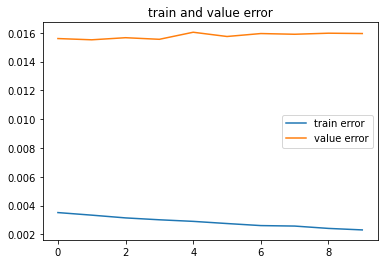

In [ ]:
plt.plot(train_loss_list,label='train error')
plt.plot(val_loss_list,label='value error')
plt.legend()
plt.title('train and value error')
plt.show()

# **载入验证集损失最低的模型**

In [ ]:
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

# **在测试集上评估模型分类效果**

测试集是之前没有见过的，相当于高考题，可以用于检验模型的泛化能力;
分析每种数字的识别准确率

In [ ]:
 # 初始化测试误差
 test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

In [ ]:
# 存储每种数字正确识别的个数
class_correct

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [ ]:
# 存储每种数字总的样本数
class_total

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [ ]:
dataiter = iter(test_loader)
data,target = dataiter.next()

torch.Size([20])

In [ ]:
data.shape

torch.Size([20, 1, 28, 28])

In [ ]:
target.shape

torch.Size([20])

In [ ]:
# 使用网络模型预测上面20个数字的数值
model.eval()
output = model(data)

In [ ]:
output.shape

torch.Size([20, 10])

In [ ]:
output[0]

tensor([ -3.5385,  -2.6597,   4.0743,   6.2439,  -5.4616,  -2.6585, -19.3619,
         18.8752,  -0.6848,   5.7572], grad_fn=<SelectBackward>)

In [ ]:
# 计算交叉熵损失
loss = criterion(output,target)
loss

tensor(0.0243, grad_fn=<NllLossBackward>)

In [ ]:
# 将本批次所有的损失函数数值求和，作为测试损失
test_loss = 0
test_loss += loss.item()*data.size(0)
test_loss

0.48576783388853073

In [ ]:
# 将输出最大值对应的神经元作为预测分类
probability,pred = torch.max(output,1)
pred

tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4])

In [ ]:
target

tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4])

In [ ]:
# 比较预测的分类和真实标签，相同则为1
correct = np.squeeze(pred.eq(target.data.view_as(pred)))
correct

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True])

In [ ]:
# 遍历本batch中的所有数字，将correct加到每个数字对应的正确识别个数上
for i in range(batch_size):
  label = target.data[i]
  class_correct[label] += correct[i].item()
  class_total[label] += 1

In [ ]:
# 每一种数字有多少被分类正确了
class_correct

[3.0, 3.0, 1.0, 1.0, 3.0, 2.0, 1.0, 2.0, 0.0, 4.0]

In [ ]:
# 每一种数字总共有多少样本
class_total

[3.0, 3.0, 1.0, 1.0, 3.0, 2.0, 1.0, 2.0, 0.0, 4.0]

# **对整个测试集进行评估**

In [ ]:
model.eval() #将模型调整为验证阶段，关闭Dropout和BN层
# 从验证集valid_loader中获取一个批次的数据和标签
for data,target in test_loader:
  # 正向预测，预测每张图片的分类
  output = model(data)
  # 将预测的结果与标签进行比较，求得交叉熵损失函数值
  loss = criterion(output,target)
  # 将本批次所有的样本损失函数的值求和，作为验证损失
  test_loss += loss.item()*data.size(0)
  # 将输出最大值对应的神经元作为预测分类
  probability,pred = torch.max(output,1)
  # 比较预测的分类和真实标签，相同则为1
  correct = np.squeeze(pred.eq(target.data.view_as(pred)))
  for i in range(batch_size):
    label = target.data[i]
    class_correct[label] += correct[i].item()
    class_total[label] += 1

#计算平均测试误差
test_loss = test_loss/len(test_loader.dataset)
print('the error on the test data is:{:.6f}'.format(test_loss))

the error on the test data is:0.070528


In [ ]:
class_correct

[972.0, 1130.0, 1014.0, 991.0, 965.0, 871.0, 945.0, 1005.0, 948.0, 988.0]

In [ ]:
class_total

[983.0, 1138.0, 1033.0, 1011.0, 985.0, 894.0, 959.0, 1030.0, 974.0, 1013.0]

In [ ]:
for i in range(10):
  print('number {} correct rate on the test data {:.5f}% ({:.0f}/{:.0f})'.format(i,class_correct[i]*100/class_total[i],class_correct[i],class_total[i]))

number 0 correct rate on the test data 98.88098% (972/983)
number 1 correct rate on the test data 99.29701% (1130/1138)
number 2 correct rate on the test data 98.16070% (1014/1033)
number 3 correct rate on the test data 98.02176% (991/1011)
number 4 correct rate on the test data 97.96954% (965/985)
number 5 correct rate on the test data 97.42729% (871/894)
number 6 correct rate on the test data 98.54015% (945/959)
number 7 correct rate on the test data 97.57282% (1005/1030)
number 8 correct rate on the test data 97.33060% (948/974)
number 9 correct rate on the test data 97.53208% (988/1013)


# **可视化测试集中的一些图片和预测结果**

括号里为真实标签，绿色为识别正确，红色为识别错误

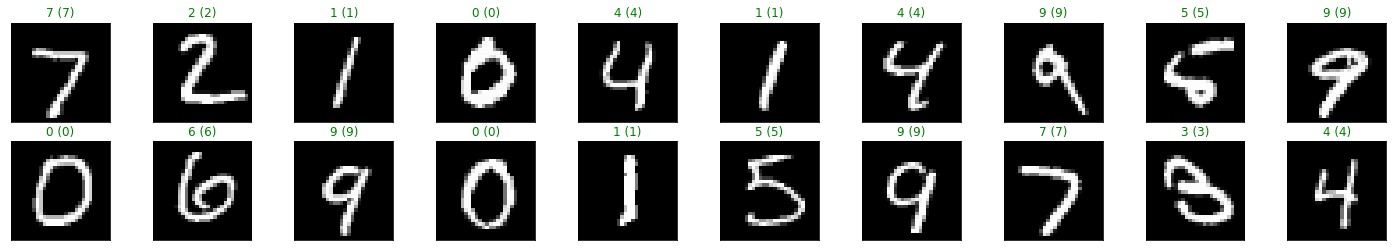

In [ ]:
# 获取数据集中的一个batch大小的数据和标签
dataiter = iter(test_loader)
images,labels = dataiter.next()

# 正向推断
output = model(images)
# 将输出最大值对应的神经元作为预测分类
probability,preds = torch.max(output,1) 
#将数据从torch张量转换为numpy的array
images = images.numpy()

#可视化本batch中的图片，预测种类，真实种类
fig = plt.figure(figsize=(25,4))
for idx in np.arange(20):
  ax = fig.add_subplot(2,20/2,idx+1,xticks=[],yticks=[])
  ax.imshow(np.squeeze(images[idx]),cmap='gray')
  ax.set_title("{} ({})".format(str(preds[idx].item()),str(labels[idx].item())),color=("green" if preds[idx]==labels[idx] else "red"))